In [3]:
import os

from pathlib import Path
import pandas as pd
import time

from visualization import training_progress

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [ ]:
import json

In [4]:
OUTPUTS_DIR = Path(
#     'outputs'
    '/Users/Stefan/Desktop/res/'
)
valid_names = [f for f in os.listdir(OUTPUTS_DIR) if '20.' in f] #+ ['dqn on lander @ 27.04 09.34-3']

In [54]:
dicts = []
for name in valid_names:
    d = {'name': name}
    try:
        with open(OUTPUTS_DIR / name / 'stats.json') as f:
            d.update(json.load(f))
    except:
        pass
    try:
        with open(OUTPUTS_DIR / name / 'agent.json') as f:
            d.update(json.load(f))
    except:
        pass
    dicts.append(d)

In [55]:
selected = pd.DataFrame(dicts).sort_values(by='tail_avg', ascending=False)
len(selected)

21

In [56]:
varying_cols = [c for c in selected if selected[c].map(str).nunique() > 1]

a single layer of 512 nodes does better than multiple layers. but it also takes way longer to train per episode.

if left for the same amount of time to train, the smaller network would likely improve over the 512 network

same for batch size

look at:
    - tail std (for it to be stable)
    - final reward (reach a good result)
    - tail avg (final reward can be small, many previous large)
    - max reward (maybe it peaked not at the end)
    - solve episode
    
tail = last 100 episodes

thus, we are motivated by reaching a high tail average in as few time as possible

we ran one studies for each hyper-parameter

but they could interact in many widely impactful ways: a higher lr can allow a larger network

or maybe higher batch size would enable more exploration 

hard lessons: `hash` WILL produce same hash for two different objects. meaning your experiments will get overwritten

double did ALL wrong

In [57]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [58]:
selected[varying_cols]

,exploration_anneal_steps,exploration_min,exploration_start,final_reward,layer_sizes,max_reward,n_eps,name,seed,solve_episode,tail_avg,tail_std,time
20,75,0.01,1.00,-320.673795,"[384, 192]",202.131395,217,(18) DQNP on LunarLander @ 11.05 20.14 [-92233...,18,NaN,161.650425,92.072479,2000.033818
19,200,0.01,0.80,208.337586,"[384, 192]",262.004737,251,(27) DQNP on LunarLander @ 11.05 20.14 [-92233...,27,250.0,133.307782,113.853267,2002.296963
5,125,0.01,1.00,63.347411,"[384, 192]",197.580923,231,(20) DQNP on LunarLander @ 11.05 20.14 [875236...,20,NaN,127.853595,119.881819,2007.066061
6,25,0.01,1.00,79.693325,"[384, 192]",250.256960,194,(0) DQNP on LunarLander @ 11.05 20.14 [-922336...,0,NaN,121.524695,124.473799,2011.059957
11,125,0.01,1.00,162.167201,"[384, 192]",234.924269,229,(4) DQNP on LunarLander @ 11.05 20.14 [-922336...,4,NaN,114.080018,144.379428,2005.463790
16,75,0.01,1.00,-56.906244,"[384, 192]",228.151225,188,(2) DQNP on LunarLander @ 11.05 20.14 [-922336...,2,NaN,100.422460,127.642828,2001.640180
12,25,0.01,1.00,50.051497,"[384, 192]",221.472729,169,(16) DQNP on LunarLander @ 11.05 20.14 [875236...,16,NaN,96.281518,148.690454,2000.259501
0,50,0.01,1.00,18.287874,"[384, 192]",221.426789,212,(17) DQNP on LunarLander @ 11.05 20.14 [-92233...,17,NaN,94.051221,149.424153,2003.656565
15,100,0.01,1.00,-115.851957,"[384, 192]",229.157263,211,(19) DQNP on LunarLander @ 11.05 20.14 [-92233...,19,NaN,83.530037,130.512787,2001.279713
8,100,0.01,1.00,68.860756,"[384, 192]",210.900564,193,(3) DQNP on LunarLander @ 11.05 20.14 [8752363...,3,NaN,77.053836,144.506837,2004.616776


batch size: 64 does much worse; 16 does a bit worse

In [22]:
selected.name.iloc[10]

'DQNP on LunarLander @ 10.05 23.30 [-9223363248361410791]'

In [63]:
selected_names = selected[selected.tail_avg > 100].name.tolist()

In [64]:
selected_names

['(18) DQNP on LunarLander @ 11.05 20.14 [-9223363284537221930-37102982218833006819]',
 '(27) DQNP on LunarLander @ 11.05 20.14 [-9223363284491754352-21983592868083147675]',
 '(20) DQNP on LunarLander @ 11.05 20.14 [8752363022102-74356492938838648601]',
 '(0) DQNP on LunarLander @ 11.05 20.14 [-9223363284537218423-43721755295060612628]',
 '(4) DQNP on LunarLander @ 11.05 20.14 [-9223363284491760398-31539359043661371902]',
 '(2) DQNP on LunarLander @ 11.05 20.14 [-9223363284491756849-27193380790638565343]']

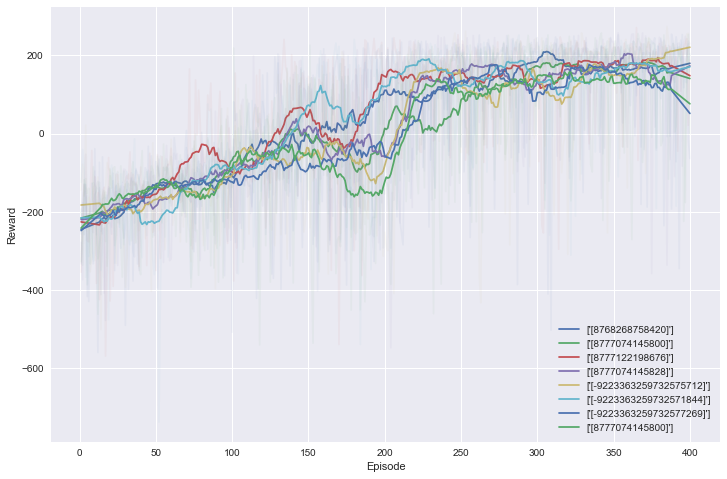

In [62]:
dfs = [pd.read_csv(OUTPUTS_DIR / f / 'train.csv') for f in selected_names]
codes = [f.split()[-4:] for f in names]
    
plt.figure(figsize=(12, 8))
training_progress_static(dfs, [25] * len(dfs), codes)
plt.legend()
plt.show()

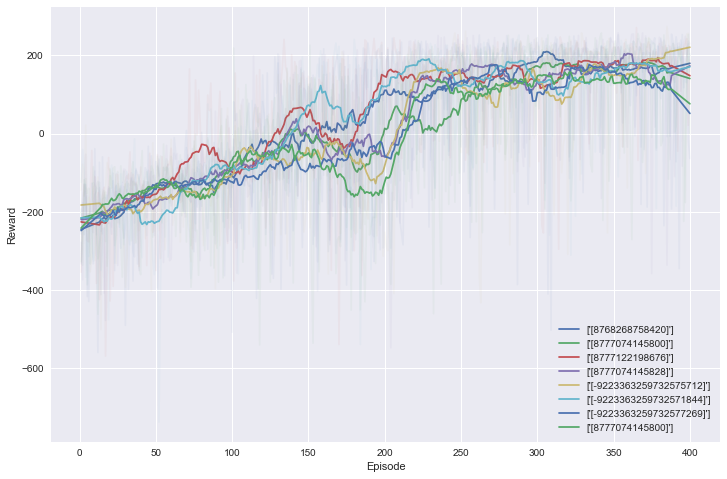

In [62]:
# 9 may
dfs = [pd.read_csv(OUTPUTS_DIR / f / 'train.csv') for f in selected_names]
codes = [f.split()[-4:] for f in names]
    
plt.figure(figsize=(12, 8))
training_progress_static(dfs, [25] * len(dfs), codes)
plt.legend()
plt.show()

https://github.com/txzhao/rl-zoo/blob/master/DQN/priorExpReplay.py

https://github.com/rlcode/per

https://github.com/jaara/AI-blog/blob/master/Seaquest-DDQN-PER.py

/Users/Stefan/.virtualenvs/rl/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


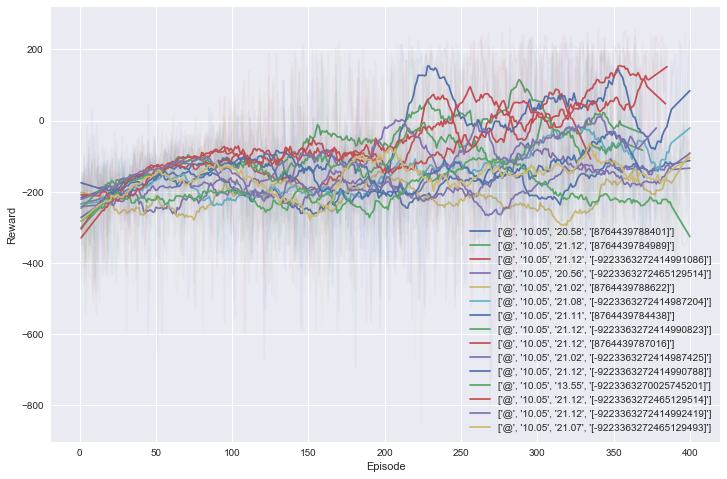

In [10]:
# 10 may
dfs = [pd.read_csv(OUTPUTS_DIR / f / 'train.csv') for f in valid_names]
codes = [f.split()[-4:] for f in valid_names]
    
plt.figure(figsize=(12, 8))
training_progress_static(dfs, [25] * len(dfs), codes)
plt.legend()
plt.show()

/Users/Stefan/.virtualenvs/rl/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


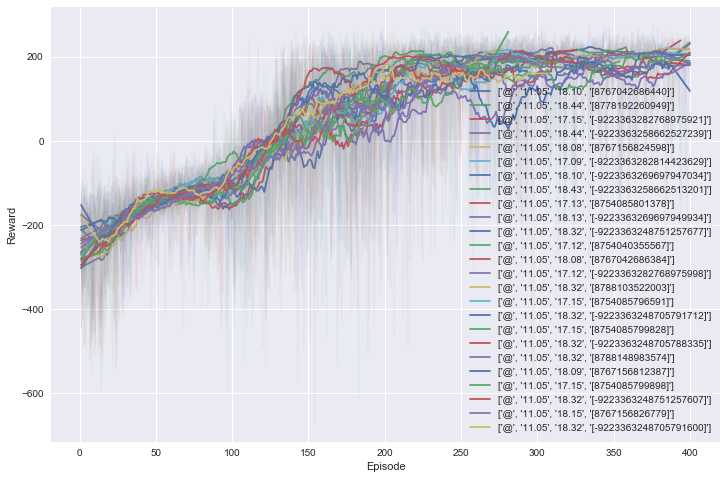

In [10]:
# 11 may - evening
dfs = [pd.read_csv(OUTPUTS_DIR / f / 'train.csv') for f in selected_names]
codes = [f.split()[-4:] for f in selected_names]
    
plt.figure(figsize=(12, 8))
training_progress_static(dfs, [25] * len(dfs), codes)
plt.legend()
plt.show()

they all start to peak when exploration is decreased

try two things:
 1. anneal faster
 2. anneal faster and enlarge min exploration
 3. anneal slower but smaller initial exlporation
 4. boltzmann exploration

/Users/Stefan/.virtualenvs/rl/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


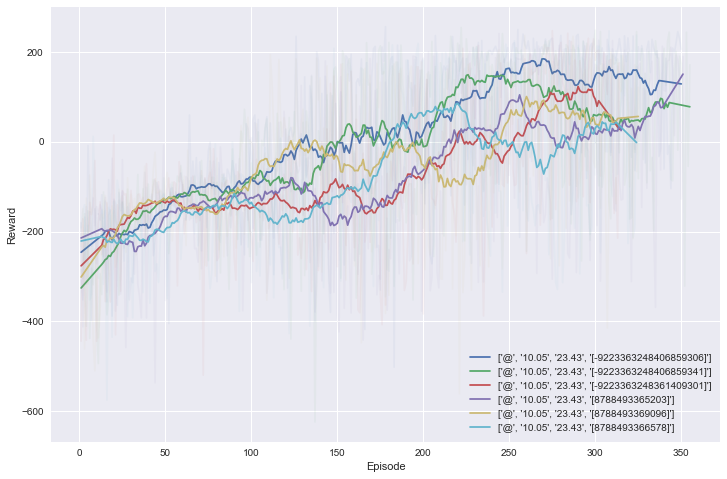

In [11]:
# 11 may
dfs = [pd.read_csv(OUTPUTS_DIR / f / 'train.csv') for f in selected_names]
codes = [f.split()[-4:] for f in selected_names]
    
plt.figure(figsize=(12, 8))
training_progress_static(dfs, [25] * len(dfs), codes)
plt.legend()
plt.show()

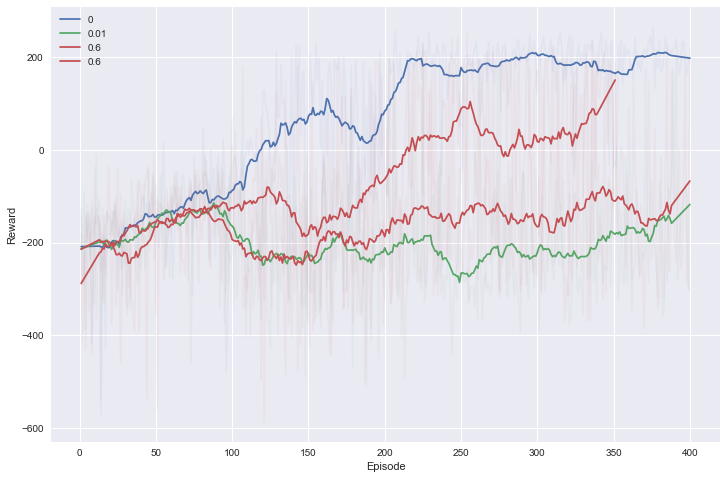

In [23]:
# 11 may -last night
dfs = [pd.read_csv(OUTPUTS_DIR / f / 'train.csv') for f in [
    'dqn on lander @ 27.04 09.34-3', 'DQNP on LunarLander @ 10.05 23.32 [-9223363248361405338]', 'DQNP on LunarLander @ 10.05 23.43 [8788493365203]', 'DQNP on LunarLander @ 10.05 23.30 [-9223363248361410791]']]
    
plt.figure(figsize=(12, 8))
training_progress_static(dfs, [25] * len(dfs), [0, .01, .6, .6])
plt.legend()
plt.show()

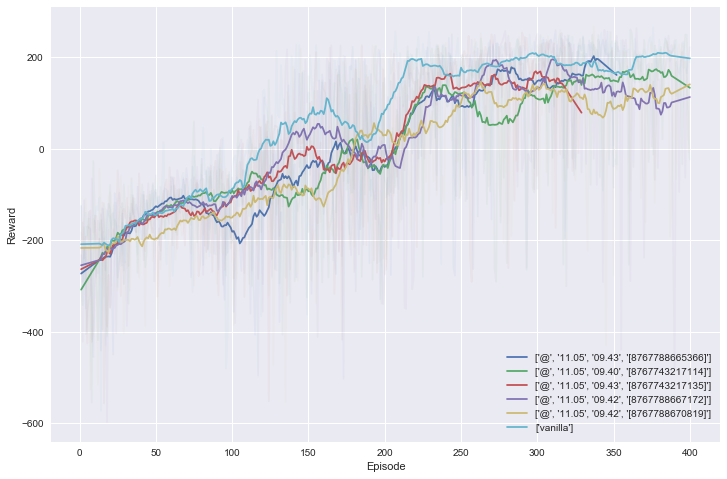

In [38]:
# 11 may
dfs = [pd.read_csv(OUTPUTS_DIR / f / 'train.csv') for f in selected_names + ['dqn on lander @ 27.04 09.34-3']]
codes = [f.split()[-4:] for f in selected_names + ['vanilla']]
    
plt.figure(figsize=(12, 8))
training_progress_static(dfs, [25] * len(dfs), codes)
plt.legend()
plt.show()

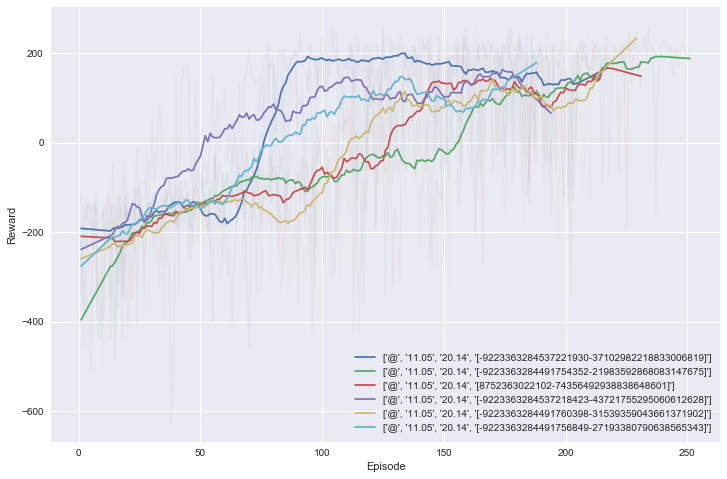

In [65]:
# 11 may - night
dfs = [pd.read_csv(OUTPUTS_DIR / f / 'train.csv') for f in selected_names]
codes = [f.split()[-4:] for f in selected_names]
    
plt.figure(figsize=(12, 8))
training_progress_static(dfs, [25] * len(dfs), codes)
plt.legend()
plt.show()

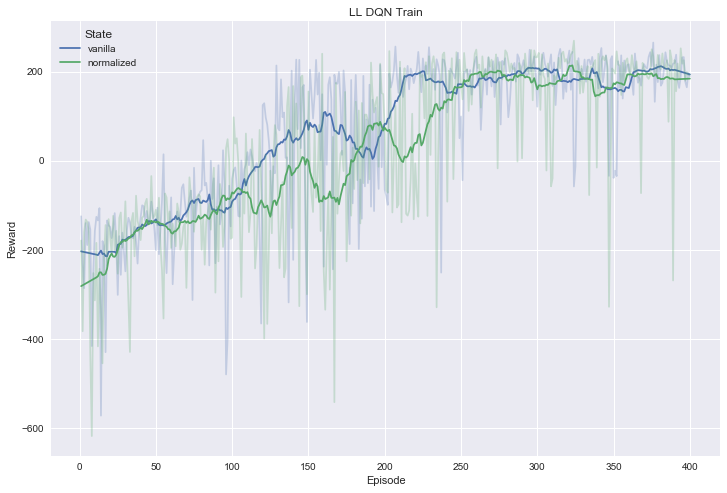

In [6]:
plt.figure(figsize=(12, 8))
training_progress_static([
    pd.read_csv(OUTPUTS_DIR / f'dqn on lander @ 27.04 09.34-3/train.csv'),
    pd.read_csv(OUTPUTS_DIR / f'dqn on lander @ 27.04 11.45-2/train.csv'),
], [20] * 2, ['vanilla', 'normalized'])

plt.title('LL DQN Train')
plt.legend(title='State')
plt.show()

/Users/Stefan/.virtualenvs/rl/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


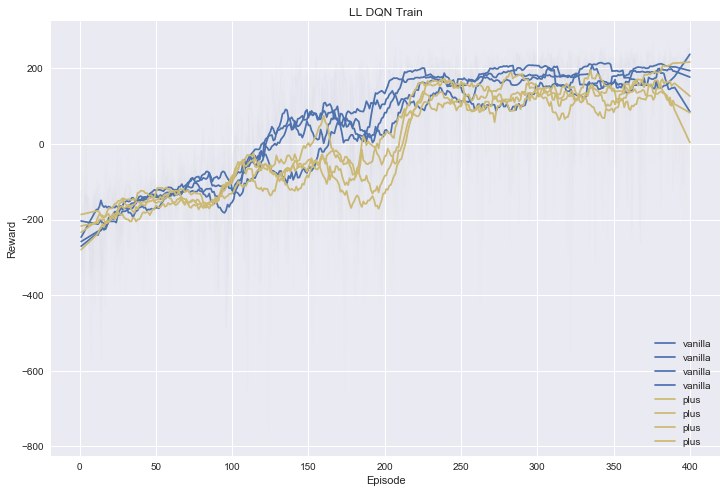

In [3]:
plt.figure(figsize=(12, 8))
training_progress_static(
    [
    pd.read_csv(OUTPUTS_DIR / f'{f}/train.csv') for f in os.listdir(OUTPUTS_DIR) if 'dqn on lander @ 27.04 09.34-' in f
    ] + [pd.read_csv(OUTPUTS_DIR / f'{f}/train.csv') for f in os.listdir(OUTPUTS_DIR) if 'DQNP on LunarLander @ 09.05' in f]
    , [20] * 8, ['vanilla']*4 + ['plus']*4)

plt.title('LL DQN Train')
plt.legend()
plt.show()

may 6 early: dqn & dqnp with constant lr, anneal exploration over 150 episodes

very noisy: reach 0 reward after around 200 episodes, then don't improve at all

/Users/Stefan/.virtualenvs/rl/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


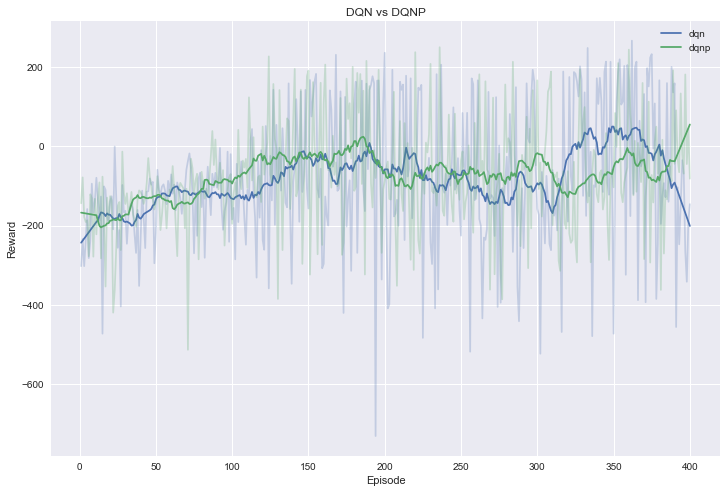

In [6]:
plt.figure(figsize=(12, 8))
training_progress_static([
    pd.read_csv(OUTPUTS_DIR / f'dqn on lander @ 06.05 10.17-3/train.csv'),
    pd.read_csv(OUTPUTS_DIR / f'dqnp on lander @ 06.05 10.16-1/train.csv'),
], [20] * 2, ['dqn', 'dqnp'])

plt.title('DQN vs DQNP')
plt.legend()
plt.show()

may 6 late: dqn with constant lr, constant exploration

dqnp with decaying lr, annealed exploration

/Users/Stefan/.virtualenvs/rl/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


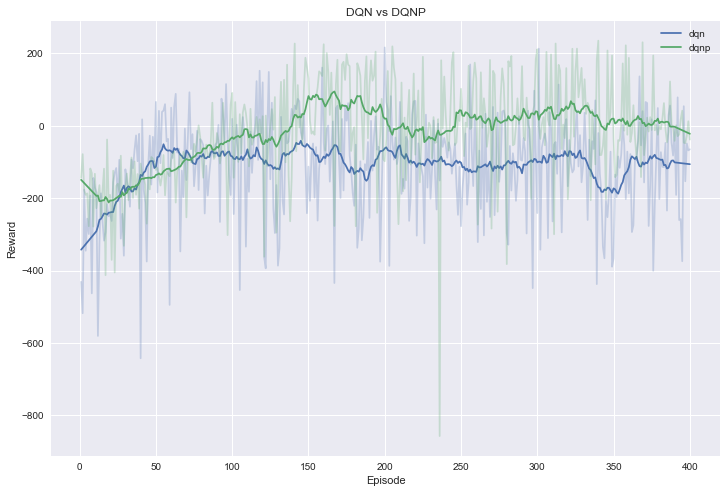

In [4]:
plt.figure(figsize=(12, 8))
training_progress_static([
    pd.read_csv(OUTPUTS_DIR / f'dqn on lander @ 06.05 22.35-1/train.csv'),
    pd.read_csv(OUTPUTS_DIR / f'dqnp on lander @ 06.05 22.40-1/train.csv'),
], [20] * 2, ['dqn', 'dqnp'])

plt.title('DQN vs DQNP')
plt.legend()
plt.show()

In [2]:
!ls /Users/Stefan/Desktop/lat-out/outputs/

DQNP on CartPole @ 08.05 21.06 [-9223363296648128673]
DQNP on CartPole @ 08.05 21.06 [8740206693503]
DQNP on CartPole @ 08.05 21.07 [8740206693738]
DQNP on CartPole @ 08.05 21.09 [8740206693226]
DQNP on LunarLander @ 08.05 21.44 [-9223363280247277182]
DQNP on LunarLander @ 08.05 21.46 [-9223363280247277154]
DQNP on LunarLander @ 08.05 21.51 [8756607498644]
DQNP on LunarLander @ 08.05 21.53 [-9223363280292723838]
dqn on lander @ 06.05 10.17-0
dqn on lander @ 06.05 10.17-1
dqn on lander @ 06.05 10.17-2
dqn on lander @ 06.05 10.17-3
dqn on lander @ 06.05 22.35-0
dqn on lander @ 06.05 22.35-1
dqn on lander @ 06.05 22.35-2
dqn on lander @ 27.04 12.54-0
dqnp on lander @ 06.05 10.14-0
dqnp on lander @ 06.05 10.14-1
dqnp on lander @ 06.05 10.16-0
dqnp on lander @ 06.05 10.16-1
dqnp on lander @ 06.05 10.16-2
dqnp on lander @ 06.05 10.16-3
dqnp on lander @ 06.05 10.16-4
dqnp on lander @ 06.05 10.16-5
dqnp on lander @ 06.05 10.16-6
dqnp on lander @ 06.05 10.16-7
dqnp on lander @ 06.05 22.40-0
dqn

In [6]:
[f for f in os.listdir('/Users/Stefan/Desktop/lat-out/outputs/') if 'DQNP on LunarLander' in f]

['DQNP on LunarLander @ 08.05 21.46 [-9223363280247277154]',
 'DQNP on LunarLander @ 08.05 21.53 [-9223363280292723838]',
 'DQNP on LunarLander @ 08.05 21.44 [-9223363280247277182]',
 'DQNP on LunarLander @ 08.05 21.51 [8756607498644]']

/Users/Stefan/.virtualenvs/rl/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


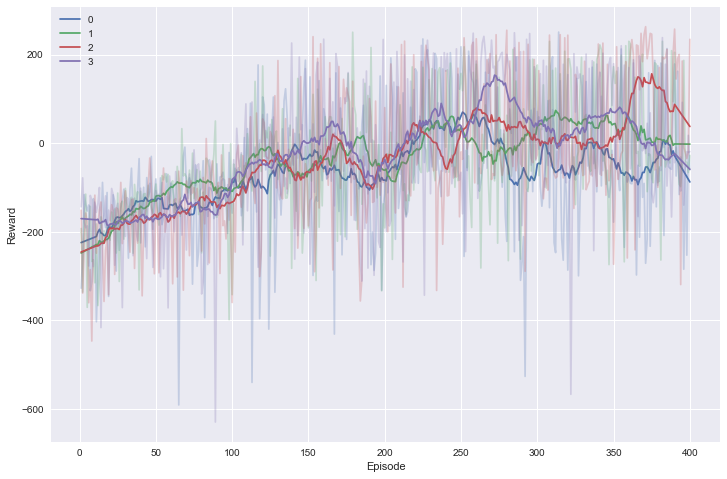

In [7]:
o = '/Users/Stefan/Desktop/lat-out/outputs/'
plt.figure(figsize=(12, 8))
training_progress_static([
    pd.read_csv(f'{o}/{f}/train.csv') for f in os.listdir('/Users/Stefan/Desktop/lat-out/outputs/') if 'DQNP on LunarLander' in f
], [20] * 4, list(range(4)))

# plt.title('DQN vs DQNP')
plt.legend()
plt.show()

takes ~20 min for dqn, about ~30min for dqnp

In [ ]:
run_files = [f'lander-{a}-observed-progress.csv' for a in ['vanilla', 'extended', 'dqn', 'dqnp']]
dfs = [pd.read_csv(OUTPUTS_DIR / f) for f in run_files]

# keep best seed
dfs = [df[df.seed == df.groupby('seed').reward.max().sort_values().index[-1]] for df in dfs]

plt.figure(figsize=(10, 6))
training_progress_static(dfs, [10, 10, 10, 5], ['QL', 'QL+', 'DQN', 'DQN+'])
plt.ylim(-700, 50)
plt.title('LunarLander')

for fmt in ['pdf', 'png']:
    plt.savefig(f'figures/lander-comparison.{fmt}', format='png', bbox_inches='tight')
    
plt.show()

In [ ]:
run_files = [f'pole-{a}-observed-progress.csv' for a in ['vanilla', 'extended']]
dfs = [pd.read_csv(OUTPUTS_DIR / f) for f in run_files]

# keep best seed
dfs = [df[df.seed == df.groupby('seed').reward.max().sort_values().index[-1]] for df in dfs]

plt.figure(figsize=(10, 6))
training_progress_static(dfs, [5, 5], ['QL', 'QL+'])
plt.title('CartPole')

for fmt in ['pdf', 'png']:
    plt.savefig(f'figures/pole-comparison.{fmt}', format='png', bbox_inches='tight')
    
plt.show()

---

In [ ]:
run_name = 'lander-extended-observed'

In [ ]:
progress_df = pd.read_csv(OUTPUTS_DIR / (run_name + '-progress.csv'), index_col=0)

In [ ]:
progress_df = progress_df[progress_df.seed.isin([9, 8, 3])]

In [ ]:
plt.figure(figsize=(10, 6))
training_progress_static(progress_df, window_size=15)
plt.ylim(-400, 0)

for fmt in ['pdf', 'png']:
    plt.savefig(f'figures/{run_name}.{fmt}', format='png', bbox_inches='tight')

---

In [ ]:
config_fields = ['env', 'agent', 'state']

In [ ]:
dfs = []

for fname in os.listdir(OUTPUTS_DIR):
    [*config, kind] = fname.split('-')
    if kind != 'runs.csv':
        continue

    df = pd.read_csv(OUTPUTS_DIR / fname, index_col=0)
    for name, value in zip(config_fields, config):
        df[name] = value
    
    dfs.append(df)
    
all_runs = pd.concat(dfs)

In [ ]:
dfs = []

for fname in os.listdir(OUTPUTS_DIR):
    [*config, kind] = fname.split('-')
    if kind != 'progress.csv':
        continue

    df = pd.read_csv(OUTPUTS_DIR / fname, index_col=0)
    for name, value in zip(config_fields, config):
        df[name] = value
    
    dfs.append(df)
    
all_prog = pd.concat(dfs)

In [ ]:
# usual time
all_runs[all_runs.state == 'observed'].pivot_table(
    index='agent',
    columns='env',
    values='time',
    aggfunc='median',
).applymap(lambda s: time.strftime("%H:%M:%S", time.gmtime(s)))

In [ ]:
# most reward
all_prog[all_prog.env == 'lander'].pivot_table(
    index='agent',
    columns='env',
    values='reward',
    aggfunc='max',
)

In [ ]:
# usual convergence
all_prog[all_prog.env == 'pole'].pivot_table(
    index='agent',
    columns='env',
    values='episode',
    aggfunc='median',
)

In [ ]:
all_prog[(all_prog.env == 'lander') & (all_prog.agent == 'vanilla') & (all_prog.episode > 45_000)].groupby('seed').reward.describe()

In [ ]:
all_prog[(all_prog.env == 'lander') & (all_prog.agent == 'extended') & (all_prog.episode > 95_000)].groupby('seed').reward.describe()

---

(0.0005, 0.005)

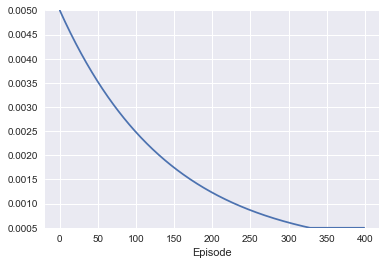

In [21]:
param_decay(400, .005, .993, .0005)
plt.ylim(.0005, .005)

In [1]:
!pip list

Package               Version     Location                    
--------------------- ----------- ----------------------------
absl-py               0.1.13      
appnope               0.1.0       
astor                 0.6.2       
backcall              0.1.0       
bayesian-optimization 0.6.0       
bleach                1.5.0       
Box2D-kengz           2.3.3       
certifi               2018.1.18   
chardet               3.0.4       
cycler                0.10.0      
dataclasses           0.5         
decorator             4.2.1       
dill                  0.2.7.1     
entrypoints           0.2.3       
future                0.16.0      
gast                  0.2.0       
GPy                   1.9.2       
GPyOpt                1.2.1       /Users/Stefan/Desktop/GPyOpt
grpcio                1.10.0      
gym                   0.10.4      
h5py                  2.7.1       
html5lib              0.9999999   
idna                  2.6         
ipykernel             4.8.2       
ipytho